This notebook shows the MEP quickstart sample, which also exists as a non-notebook version at:
https://bitbucket.org/vitotap/python-spark-quickstart

It shows how to use Spark (http://spark.apache.org/) for distributed processing on the PROBA-V Mission Exploitation Platform. (https://proba-v-mep.esa.int/) The sample intentionally implements a very simple computation: for each PROBA-V tile in a given bounding box and time range, a histogram is computed. The results are then summed and printed. Computation of the histograms runs in parallel.
## First step: get file paths
A catalog API is available to easily retrieve paths to PROBA-V files:
https://readthedocs.org/projects/mep-catalogclient/

In [1]:
from catalogclient import catalog
cat=catalog.Catalog()
cat.get_producttypes()

[u'BioPar_ALB_BHV_V1_Tiles',
 u'BioPar_ALB_DHV_V1_Tiles',
 u'BioPar_BA_V1_Tiles',
 u'BioPar_DMP_Tiles',
 u'BioPar_FAPAR_V1_Tiles',
 u'BioPar_FCOVER_V1_Tiles',
 u'BioPar_LAI_V1_Tiles',
 u'BioPar_NDVI300_V1_Global',
 u'BioPar_BA300_V1_Global',
 u'BioPar_FCOVER300_V1_Global',
 u'BioPar_FAPAR300_V1_Global',
 u'BioPar_LAI300_V1_Global',
 u'BioPar_NDVI_V1_Tiles',
 u'BioPar_NDVI_V2_Tiles',
 u'BioPar_NDVI_V2_Global',
 u'BioPar_SWI',
 u'BioPar_SWI10_V3_Global',
 u'BioPar_TOCR_Tiles',
 u'BioPar_VCI_Tiles',
 u'BioPar_VPI_Tiles',
 u'BioPar_WB_V1_Tiles',
 u'BioPar_WB_V2_Tiles',
 u'PROBAV_L3_S1_TOC_1KM',
 u'PROBAV_L3_S1_TOC_333M',
 u'PROBAV_L3_S10_TOC_333M',
 u'PROBAV_L3_S5_TOC_100M',
 u'PROBAV_L3_S1_TOC_100M',
 u'PROBAV_L3_S10_TOC_1KM',
 u'PROBAV_L3_S1_TOA_1KM',
 u'PROBAV_L3_S1_TOA_333M',
 u'PROBAV_L3_S5_TOA_100M',
 u'PROBAV_L3_S1_TOA_100M',
 u'PROBAV_L3_S10_TOA_1KM',
 u'PROBAV_L3_S10_TOA_333M',
 u'PROBAV_L1C',
 u'SPOTVEGETATION_L3_S1',
 u'SPOTVEGETATION_L3_S10']

In [2]:
import datetime
date = datetime.date(2016, 1, 1)
products = cat.get_products('PROBAV_L3_S1_TOC_333M', 
                            fileformat='GEOTIFF', 
                            startdate=date, 
                            enddate=date, 
                            min_lon=0, max_lon=10, min_lat=36, max_lat=53)
#extract NDVI geotiff files from product metadata
files = map(lambda p: filter(lambda f: 'NDVI' in f.bands,p.files)[0].filename[5:],products)
print('Found '+str(len(files)) + ' files.')
print(files[0])
#check if file exists
!file {files[0]}

Found 2 files.
/data/MTDA/TIFFDERIVED/PROBAV_L3_S1_TOC_333M/2016/20160101/PROBAV_S1_TOC_20160101_333M_V101/PROBAV_S1_TOC_X18Y02_20160101_333M_V101_NDVI.tif
/data/MTDA/TIFFDERIVED/PROBAV_L3_S1_TOC_333M/2016/20160101/PROBAV_S1_TOC_20160101_333M_V101/PROBAV_S1_TOC_X18Y02_20160101_333M_V101_NDVI.tif: TIFF image data, little-endian


## Second step: define function to apply
Define the histogram function, this can also be done inline, which allows for a faster feedback loop when writing the code, but here we want to clearly separate the processing 'algorithm' from the parallelization code.

In [3]:
# Calculates the histogram for a given (single band) image file.
def histogram(image_file):
    
    import numpy as np
    import gdal
    
    
    # Open image file
    img = gdal.Open(image_file)
    
    if img is None:
        print '-ERROR- Unable to open image file "%s"' % image_file
    
    # Open raster band (first band)
    raster = img.GetRasterBand(1)    
    xSize = img.RasterXSize
    ySize = img.RasterYSize
    
    # Read raster data
    data = raster.ReadAsArray(0, 0, xSize, ySize)
        
    # Calculate histogram
    hist, _ = np.histogram(data, bins=256)
    return hist


## Third step: setup Spark
To work on the processing cluster, we need to specify the resources we want:
* spark.executor.instances: The number of workers (executors) we will use. This is usually proportional to the extent in which we can divide the work in separate tasks. If we only run on 2 tiles, then it does not make sense to use more than 2 workers.
* spark.executor.cores: Number of cores per executor. Usually our tasks are single threaded, so 1 is a good default.
* spark.executor.memory: memory to assign per executor. For remote sensing products, it's quite common to use a few Gigabytes.

We set up the SparkConf with these parameters, and create a SparkContext sc, which will be our access point to the cluster.

In [4]:
# ================================================================
# === Calculate the histogram for a given number of files. The ===
# === processing is performed by spreading them over a cluster ===
# === of Spark nodes.                                          ===
# ================================================================

from datetime import datetime
from operator import add
import pyspark

# Setup the Spark cluster
conf = pyspark.SparkConf()
conf.set('spark.yarn.executor.memoryOverhead', 1024)
conf.set('spark.executor.memory', '4g')
conf.set('spark.executor.cores', '1')
conf.set('spark.executor.instances', 2)
sc = pyspark.SparkContext(conf=conf)

## Fourth cell: compute histograms
We use a couple of Spark functions to run our job on the cluster. Comments are provided in the code.

In [5]:
# Distribute the local file list over the cluster.
filesRDD = sc.parallelize(files)

# Apply the 'histogram' function to each filename using 'map', keep the result in memory using 'cache'.
hists = filesRDD.map(histogram).cache()

count = hists.count()

# Combine distributed histograms into a single result
total = hists.reduce(lambda h, i: map(add, h, i))

print "Sum of %i histograms: %s" % (count, total)

Sum of 2 histograms: [654193, 63823, 61682, 68119, 67839, 72141, 74221, 77644, 81447, 86393, 89683, 103483, 110195, 121177, 136138, 154763, 184321, 220988, 275457, 361887, 542747, 684021, 900909, 1174650, 1365573, 1156187, 841369, 645124, 510698, 424658, 354549, 313612, 280477, 255020, 235359, 224484, 211826, 199581, 184397, 173696, 165003, 155257, 148290, 142473, 137691, 133740, 130434, 127275, 125257, 122274, 121166, 118215, 116689, 114504, 113817, 110121, 108602, 106677, 102750, 101537, 98107, 96552, 94591, 92763, 90640, 87984, 85681, 84069, 81654, 79944, 78599, 76273, 74443, 73064, 70554, 69129, 67624, 66310, 64458, 64226, 62432, 61680, 59466, 60326, 58542, 57456, 56427, 55700, 54616, 53549, 53763, 52796, 51371, 51553, 50544, 49812, 49756, 49236, 49127, 48600, 47761, 48000, 47598, 47314, 46795, 47192, 47040, 46851, 46362, 46575, 46373, 45937, 46420, 46148, 45801, 45751, 45996, 45653, 45130, 45838, 45178, 45157, 45360, 45079, 44892, 44597, 44721, 44171, 43783, 43735, 43649, 43264, 4

## Fifth step: plot our result
Plot the array of values as a simple line chart using matplotlib. This is the most basic Python library. More advanced options such as bokeh, mpld3 and seaborn are also available.

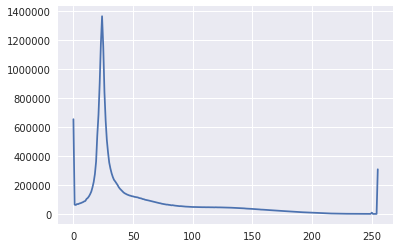

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(total)
plt.show()